### **0. Instalacion e imports de librerias**

In [213]:
import sys
# Version 3.8 de Python requerida
#!{sys.executable} -m pip install --upgrade pip
#!{sys.executable} -m pip install contexto
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install openpyxl
#!{sys.executable} -m pip install seaborn

In [214]:
from contexto.limpieza import limpieza_texto, lista_stopwords, remover_stopwords
from contexto.stemming import Stemmer, stem_texto
from contexto.vectorizacion import VectorizadorFrecuencias
from contexto.lenguajes import detectar_lenguaje

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### **1. Exploracion de datos**

In [215]:
df = pd.read_excel('cat_6716.xlsx')

In [216]:
# Contar valores nulos
df.isnull().sum()

Textos_espanol    0
sdg               0
dtype: int64

In [217]:
# Contar duplicados
df.duplicated().sum()

0

In [218]:
# Detectar si hay otros idiomas ademas de español.

#df['lang'] = df['Textos_espanol'].apply(detectar_lenguaje)
#df['lang'].value_counts()

In [219]:
# Imprimir los textos que no son español
#for i in range(len(df)):
#    if df['lang'][i] != 'es':
#       print(i, df['Textos_espanol'][i])

In [220]:
# Dado que hay frases en ingles, estas se eliminan.
#df = df[df['lang'] == 'es']
#df['lang'].value_counts()

In [221]:
df.head()

,Textos_espanol,sdg
0,"Es importante destacar que, en un año de sequí...",6
1,Hay una gran cantidad de literatura sobre Aust...,6
2,"Los procesos de descentralización, emprendidos...",6
3,Esto puede tener consecuencias sustanciales pa...,6
4,La función de beneficio también incorpora pará...,6


### **2. Separacion de datos**

In [222]:
X, Y = df['Textos_espanol'], df['sdg']
Y = Y.astype(int)
Y.head()

0    6
1    6
2    6
3    6
4    6
Name: sdg, dtype: int32

In [223]:
X.head()

0    Es importante destacar que, en un año de sequí...
1    Hay una gran cantidad de literatura sobre Aust...
2    Los procesos de descentralización, emprendidos...
3    Esto puede tener consecuencias sustanciales pa...
4    La función de beneficio también incorpora pará...
Name: Textos_espanol, dtype: object

In [224]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [225]:
X_train.head()

2370    Lograr el respeto de los derechos humanos por ...
1774    Diseño de proyectos sostenibles de electrifica...
731     En las partes españolas de las cuencas del Due...
271     Garantizar que los arreglos de gobernanza ayud...
1077    Además, a nivel de plantas y unidades, no hay ...
Name: Textos_espanol, dtype: object

### **3. Construcción del Pipeline**

Para el pipeline, se realiza la limpieza, normalización (stemmming), vectorización y clasificación de los datos.

In [226]:
"""
Limpieza de datos. La funcion limpieza_texto hace lo siguiente:
    - Pasar todo el texto a minúsculas
    - Quitar signos de puntuación
    - Quitar números (configurable): True
    - Quitar acentos (configurable). True

Luego, se remueven las stopwords del texto. Para esto, se utiliza la función remover_stopwords.
"""

class TextTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.stopwords = lista_stopwords()
        return self
    
    def transform(self, X):
        X = X.apply(lambda x: self.preprocess_text(x))
        return X
    
    def preprocess_text(self, texto):
        texto = limpieza_texto(texto=texto, quitar_numeros=True, quitar_acentos=True)
        texto = remover_stopwords(texto, self.stopwords)
        return texto

In [227]:
"""
Normalización de datos. Se utiliza la función stem_texto para realizar el stemming de los textos.
El Stemmer se inicializa antes con el objetivo de que no se cree uno nuevo por cada texto.
"""
class NormalizeTokens(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.stemmer = Stemmer(lenguaje='español')
        return self
    
    def transform(self, X):
        X = X.apply(lambda x: self.normalize_text(x))
        return X
    
    def normalize_text(self, texto):
        texto = stem_texto(texto=texto, stemmer=self.stemmer)
        return texto

In [228]:
"""
Vectorización de datos. Se utiliza la clase VectorizadorFrecuencias para realizar la vectorización de los textos.
Se crea un vectorizador antes con el objetivo de que no se cree uno nuevo por cada texto.
"""

class VectorizeTokens(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        # Construcción del vectorizador usando X_train. Se hacer una lista, 
        # donde cada elemento es un string de la posicion Textos_espanol
        textos = [x for x in X]
        self.v_bow = VectorizadorFrecuencias(tipo='bow')
        self.v_bow.ajustar(textos)
        return self
    
    def transform(self, X):
        X = X.apply(lambda x: self.vectorize_text(x))
        X = X.values.tolist()
        return X
    
    def vectorize_text(self, texto):
        texto = self.v_bow.vectorizar(textos=texto, disperso=False)
        # Se convierte a array para que sea compatible con el resto de los pasos
        # v_bow.inversa(X_vector[0]). Retorna las palabras que corresponden a cada posición del vector
        texto = texto.ravel()
        return texto

In [229]:
# Entrenamiento y construcción del modelo.
pipeline = Pipeline(
    [
        ("text_transformer", TextTransformer()),
        ("normalize_tokens", NormalizeTokens()),
        ("vectorize_tokens", VectorizeTokens()),
        ("classifier", ComplementNB()) # 6. Modelo Clasificador #1 - Complement Naive Bayes (CNB)
    ]
)   
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('text_transformer', TextTransformer()),
                ('normalize_tokens', NormalizeTokens()),
                ('vectorize_tokens', VectorizeTokens()),
                ('classifier', ComplementNB())])

In [230]:
# Evaluación del modelo con los datos de prueba.
y_pred = pipeline.predict(X_test)

In [231]:
print("Number of mislabeled points out of a total %d points : %d" 
      % (X_test.shape[0], (Y_test != y_pred).sum()))
print("Porcentaje de acierto: ", (Y_test == y_pred).sum() / Y_test.shape[0] * 100)

Number of mislabeled points out of a total 600 points : 10
Porcentaje de acierto:  98.33333333333333


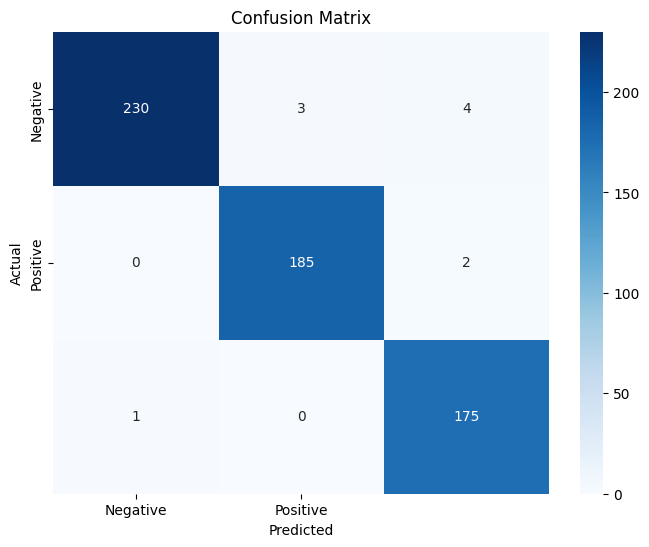

In [232]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()